# Library Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import os
import random
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Import necessary libraries............................
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
#from torchvision.transforms import v2
from torchvision import transforms, models
from torch.optim import lr_scheduler
import torch.nn.functional as F # activation function
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Dataset
from tempfile import TemporaryDirectory
from torchsummary import summary
import time
%matplotlib inline

In [2]:
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  Tesla P100-PCIE-16GB
Using device: cuda


# Banana Image Dataset imported

In [3]:
dataset_path = "/kaggle/input/banana-ripeness-classification-classification"

# Analyze dataset structure to understand what files are available
def analyze_dataset(root_dir):
    structure = {}
    for root, dirs, files in os.walk(root_dir):
        rel_dir = os.path.relpath(root, root_dir)
        if rel_dir == '.':
            continue
            
        # Count files by extension
        file_counts = {}
        for f in files:
            ext = os.path.splitext(f)[1].lower()
            if ext in file_counts:
                file_counts[ext] += 1
            else:
                file_counts[ext] = 1
                
        structure[rel_dir] = file_counts
        
    return structure

dataset_structure = analyze_dataset(dataset_path)
print("Dataset structure:")
for dir_path, file_types in dataset_structure.items():
    print(f"{dir_path}: {file_types}")

Dataset structure:
valid: {}
valid/unripe: {'.jpg': 167}
valid/overripe: {'.jpg': 229}
valid/rotten: {'.jpg': 388}
valid/ripe: {'.jpg': 339}
test: {}
test/unripe: {'.jpg': 110}
test/overripe: {'.jpg': 113}
test/rotten: {'.jpg': 185}
test/ripe: {'.jpg': 154}
train: {}
train/unripe: {'.jpg': 1902}
train/overripe: {'.jpg': 2349}
train/rotten: {'.jpg': 4020}
train/ripe: {'.jpg': 3522}


# Data Loading and Preprocessing

In [4]:
train_dir = "/kaggle/input/banana-ripeness-classification-classification/train"

test_dir = "/kaggle/input/banana-ripeness-classification-classification/test"

valid_dir = "/kaggle/input/banana-ripeness-classification-classification/valid"

clouds_classes = os.listdir(train_dir)

In [ ]:
print('Total Banana Ripeness Class ', len(os.listdir(train_dir)))

class_names = ['unripe','overripe','rotten','ripe']

Total Clouds Class  4


In [6]:
train_transform = transforms.Compose([
    transforms.Resize((384,384)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=18),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the data to [-1, 1]
])

val_transform = transforms.Compose([
    transforms.Resize((384,384)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the data to [-1, 1]
])



In [7]:
train = datasets.ImageFolder(
    root = train_dir,
    transform = train_transform
)

valid = datasets.ImageFolder(
    root=valid_dir, 
    transform=val_transform
)

test = datasets.ImageFolder(
    root=test_dir, 
    transform=val_transform
)

print(f'Train dataset : {len(train)}, {type(train)}')

print(f'Validation dataset : {len(valid)}')


Train dataset : 11793, <class 'torchvision.datasets.folder.ImageFolder'>
Validation dataset : 1123


# Create a custom dataset

In [8]:
# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [9]:
# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

# Train and valid Dataloader

In [10]:
batch_size = 32
# DataLoaders for training and validation
train_loader = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid, batch_size,shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test, batch_size,shuffle=False, num_workers=2, pin_memory=True)


In [11]:
# Moving data into GPU, WrappedDataLoader
train_dataloader = DeviceDataLoader(train_loader, device)
valid_dataloader = DeviceDataLoader(valid_loader, device)

# Sample Image show after Augmentation

torch.Size([32, 3, 384, 384])
Augmented Image:


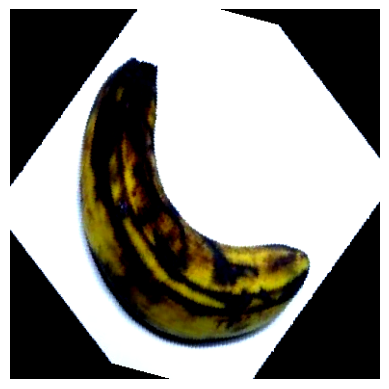

Label: overripe
Original Valid Image:


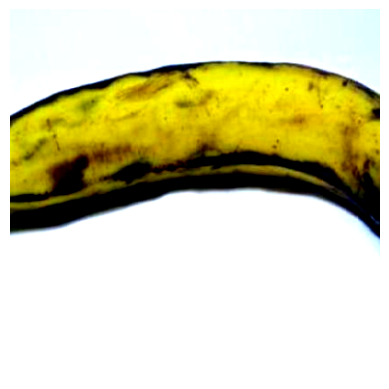

Label: overripe
Batch of Augmented Images:


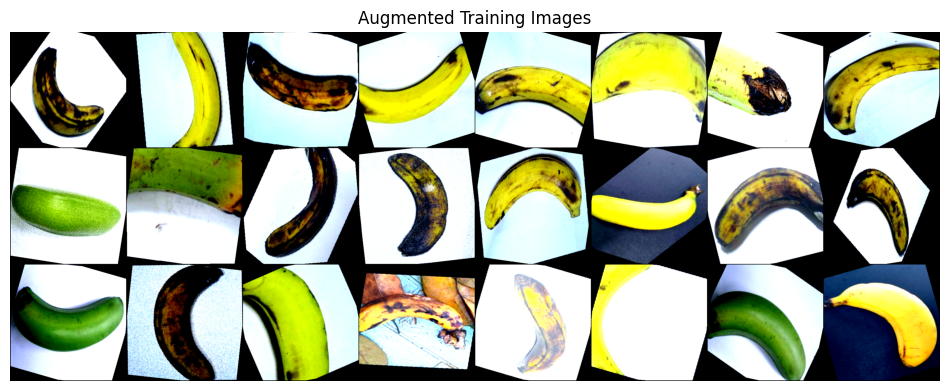

Labels: overripe ripe overripe ripe ripe ripe rotten ripe unripe rotten rotten overripe overripe ripe overripe overripe unripe overripe ripe rotten overripe ripe unripe ripe


In [12]:
# Function to show an image
def imshow(img):
    """Display unnormalized image from a torch Tensor."""
    img = img.clone().detach()  # detach from graph
    img = img / 2 + 0.5         # unnormalize assuming mean=0.5, std=0.5
    npimg = img.numpy()

    # Check if single channel (grayscale) or 3-channel (RGB)
    if npimg.shape[0] == 1:
        npimg = npimg.squeeze()  # remove channel dimension
        plt.imshow(npimg, cmap='gray')
    else:
        npimg = np.transpose(npimg, (1, 2, 0))  # CxHxW → HxWxC
        plt.imshow(npimg)

    plt.axis('off')
    plt.show()


# # # Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)

# # Show one augmented image
print('Augmented Image:')
imshow(images[0])
print('Label:', train.classes[labels[0]])

# Get some random test images (without augmentation)
valid_dataiter = iter(valid_loader)
valid_images, valid_labels = next(valid_dataiter)

# Show one original test image
print('Original Valid Image:')
imshow(valid_images[0])
print('Label:', valid.classes[valid_labels[0]])

# 3. Visualizing Augmented Images

# Function to display a batch of images..........................
def imshow_batch(img_batch, labels_batch, title, data):
    img_batch = img_batch / 2 + 0.5  # Unnormalize
    npimg = torchvision.utils.make_grid(img_batch, nrow=8)
    npimg = npimg.numpy()
    plt.figure(figsize=(12, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze())
    plt.title(title)
    plt.axis('off')
    plt.show()
    # Print labels
    print('Labels:', ' '.join(f'{data.classes[labels_batch[j]]}' for j in range(len(labels_batch))))


# Display a batch of augmented images
print('Batch of Augmented Images:')
imshow_batch(images[:24], labels[:24], 'Augmented Training Images', train)

# # Display a batch of original test images
# print('Batch of Original Valid Images:')
# imshow_batch(valid_images[:24], valid_labels[:24], 'Original Valid Images', valid)

In [13]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        #images, labels = images.to(DEVICE), labels.to(DEVICE) # move to GPU
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        #images, labels = images.to(DEVICE), labels.to(DEVICE) # move to GPU
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

# Custom resnet architecture 

In [16]:
# resnet architecture 
class CNN_NeuralNet(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) 
        self.conv4 = ConvBlock(256, 512, pool=True)
        #self.conv5 = ConvBlock(256, 256, pool=True)
        #self.conv6 = ConvBlock(256, 512, pool=True)
        #self.conv7 = ConvBlock(512, 512, pool=True)
        
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        # self.classifier = nn.Sequential(nn.MaxPool2d(4),
        #                                nn.Flatten(),
        #                                nn.Linear(512, num_diseases))
        
        self.classifier = nn.Sequential(
                nn.AdaptiveAvgPool2d((1, 1)),  # Safe replacement
                nn.Flatten(),
                nn.Linear(512, num_diseases)
        )
        
    def forward(self, x): # x is the loaded batch
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        #out = self.conv5(out)
        #out = self.conv6(out)
        #out = self.conv7(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        
        return out        

In [17]:
# defining the model and moving it to the GPU
# 3 is number of channels RGB, len(train.classes()) is number of diseases.
model = to_device(CNN_NeuralNet(3, len(class_names)), device) 
#model = model.to(DEVICE)
model

CNN_NeuralNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

In [18]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [19]:
def get_lr(optimizer):
    if optimizer is None:
        raise ValueError("Optimizer is not defined.")
    if not optimizer.param_groups:
        raise ValueError("Optimizer has no param groups.")
    else:
        for param_group in optimizer.param_groups:
            return param_group['lr']

In [20]:
%%time
history = [evaluate(model, valid_dataloader)]
history

CPU times: user 5.49 s, sys: 1.21 s, total: 6.7 s
Wall time: 8.86 s


[{'val_loss': 1.3847192525863647, 'val_acc': 0.3185763955116272}]

# Hyperparameters Function:

Now it's time to create a function that get epochs, learning rate, train and validation loader and optim function..

Clear GPU memory after PyTorch model training without restarting kernel with torch.cuda.empty_cache()

In [21]:
def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []  #For collecting the results
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    #Sets the learning rate of each parameter group according to the 1cycle learning rate policy. 
    #The 1cycle policy anneals the learning rate from an initial learning rate to some 
    #maximum learning rate and then from that maximum learning rate to some minimum learning rate
    #much lower than the initial learning rate. 
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,
                                                epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            #Clip the gradients of an iterable of parameters at specified value.
            #All from pytorch documantation.
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
             # validation
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    torch.save(model.state_dict(), 'resnet_Model.pth')
    return history

# Training Model:

Evaluate function added to history of model.

Then we can define our hyperparameters like number of epochs, learning rate and ... .

Now we can update history with fit_OneCycle function (Adding two function together). Attention to history = [] in the second function. Now we have model evaluation.

In [22]:
num_epoch = 30
lr_rate = 0.001
grad_clip = 0.15
weight_decay = 1e-4
optims = torch.optim.AdamW

history = fit_OneCycle(num_epoch, lr_rate, model, train_dataloader, valid_dataloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=optims)

Epoch 1/30: 100%|██████████| 369/369 [02:51<00:00,  2.15it/s]


Epoch [0], train_loss: 0.3270, val_loss: 0.3052, val_acc: 0.8854


Epoch 2/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [1], train_loss: 0.2316, val_loss: 0.2525, val_acc: 0.9132


Epoch 3/30: 100%|██████████| 369/369 [02:50<00:00,  2.16it/s]


Epoch [2], train_loss: 0.2066, val_loss: 0.1653, val_acc: 0.9505


Epoch 4/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [3], train_loss: 0.2083, val_loss: 0.1728, val_acc: 0.9280


Epoch 5/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [4], train_loss: 0.1734, val_loss: 0.1244, val_acc: 0.9670


Epoch 6/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [5], train_loss: 0.1611, val_loss: 0.5804, val_acc: 0.8438


Epoch 7/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [6], train_loss: 0.1629, val_loss: 0.1440, val_acc: 0.9601


Epoch 8/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [7], train_loss: 0.1338, val_loss: 0.1365, val_acc: 0.9549


Epoch 9/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [8], train_loss: 0.1356, val_loss: 0.1037, val_acc: 0.9714


Epoch 10/30: 100%|██████████| 369/369 [02:50<00:00,  2.16it/s]


Epoch [9], train_loss: 0.1181, val_loss: 0.1767, val_acc: 0.9540


Epoch 11/30: 100%|██████████| 369/369 [02:50<00:00,  2.16it/s]


Epoch [10], train_loss: 0.1212, val_loss: 0.0941, val_acc: 0.9722


Epoch 12/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [11], train_loss: 0.0999, val_loss: 0.0723, val_acc: 0.9826


Epoch 13/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [12], train_loss: 0.0923, val_loss: 0.0796, val_acc: 0.9818


Epoch 14/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [13], train_loss: 0.0931, val_loss: 0.0927, val_acc: 0.9774


Epoch 15/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [14], train_loss: 0.0735, val_loss: 0.2105, val_acc: 0.9314


Epoch 16/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [15], train_loss: 0.0699, val_loss: 0.1126, val_acc: 0.9635


Epoch 17/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [16], train_loss: 0.0681, val_loss: 0.0640, val_acc: 0.9818


Epoch 18/30: 100%|██████████| 369/369 [02:50<00:00,  2.16it/s]


Epoch [17], train_loss: 0.0689, val_loss: 0.0583, val_acc: 0.9809


Epoch 19/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [18], train_loss: 0.0492, val_loss: 0.0596, val_acc: 0.9818


Epoch 20/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [19], train_loss: 0.0493, val_loss: 0.0667, val_acc: 0.9835


Epoch 21/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [20], train_loss: 0.0446, val_loss: 0.0536, val_acc: 0.9835


Epoch 22/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [21], train_loss: 0.0390, val_loss: 0.0419, val_acc: 0.9844


Epoch 23/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [22], train_loss: 0.0330, val_loss: 0.0510, val_acc: 0.9852


Epoch 24/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [23], train_loss: 0.0260, val_loss: 0.0594, val_acc: 0.9844


Epoch 25/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [24], train_loss: 0.0241, val_loss: 0.0467, val_acc: 0.9852


Epoch 26/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [25], train_loss: 0.0202, val_loss: 0.0363, val_acc: 0.9878


Epoch 27/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [26], train_loss: 0.0180, val_loss: 0.0421, val_acc: 0.9844


Epoch 28/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [27], train_loss: 0.0146, val_loss: 0.0424, val_acc: 0.9878


Epoch 29/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [28], train_loss: 0.0151, val_loss: 0.0423, val_acc: 0.9878


Epoch 30/30: 100%|██████████| 369/369 [02:51<00:00,  2.16it/s]


Epoch [29], train_loss: 0.0136, val_loss: 0.0405, val_acc: 0.9887


In [23]:
val_acc = []
val_loss = []
train_loss = []

for i in history:
    val_acc.append(i['val_acc'])
    val_loss.append(i['val_loss'])
    train_loss.append(i.get('train_loss'))

# Loss per Epochs curve

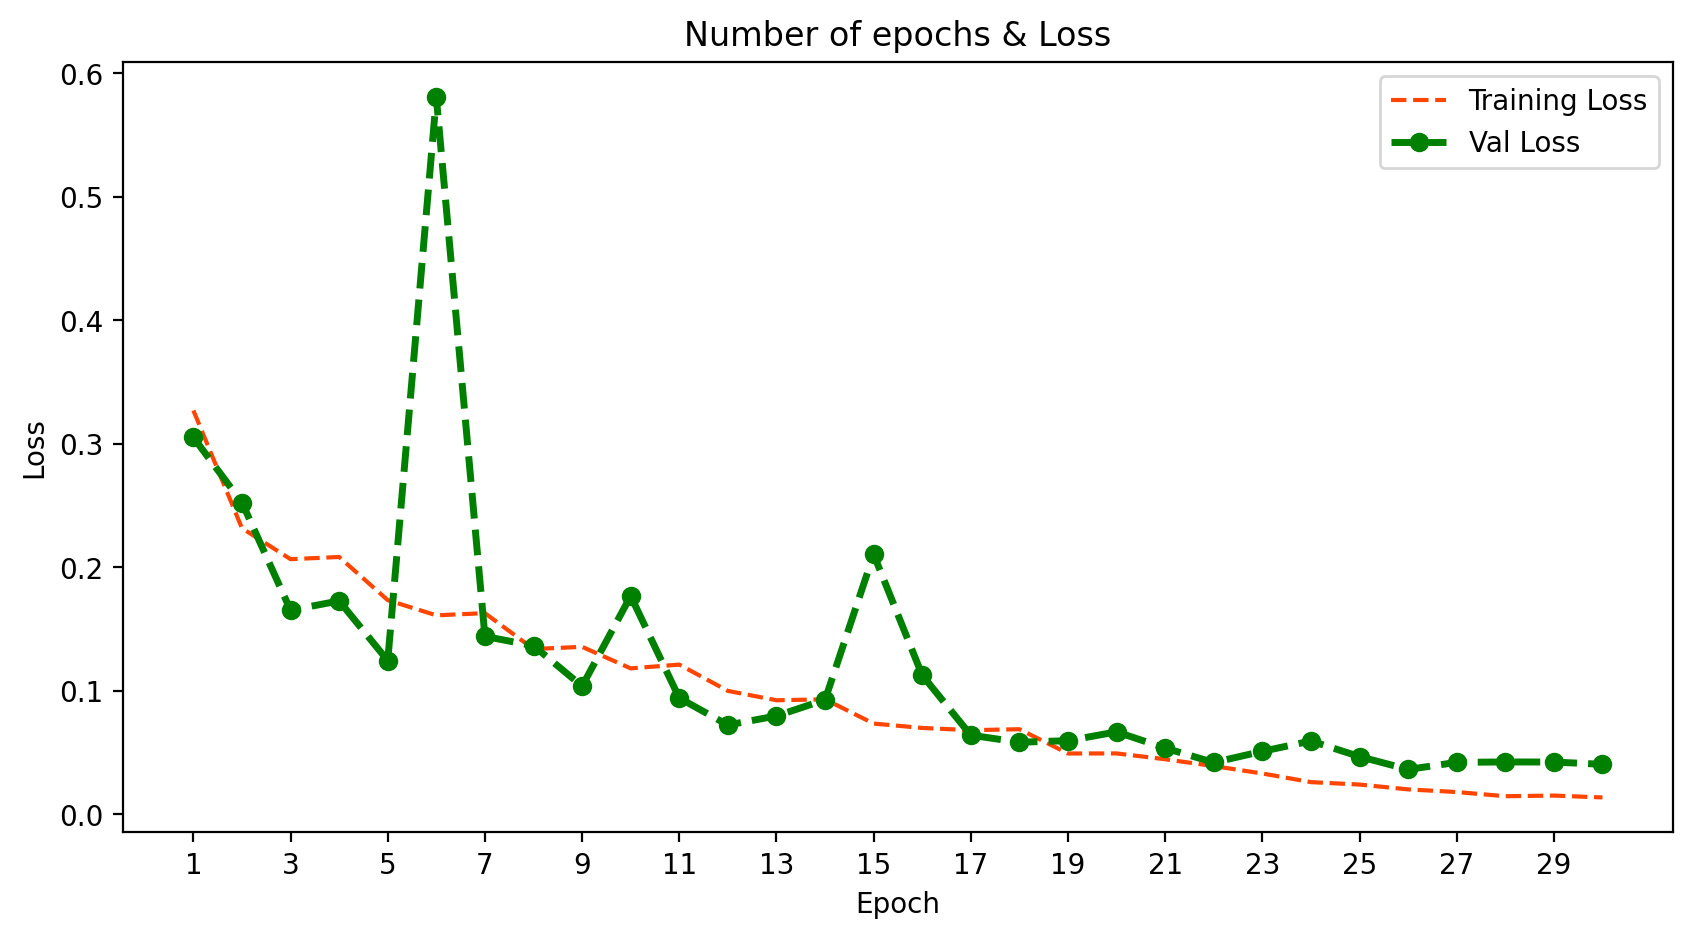

In [24]:
epoch_count = range(1,31)

plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, train_loss, 'r--', color= 'orangered')
plt.plot(epoch_count, val_loss, '--bo',color= 'green', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,31,2))
plt.show();

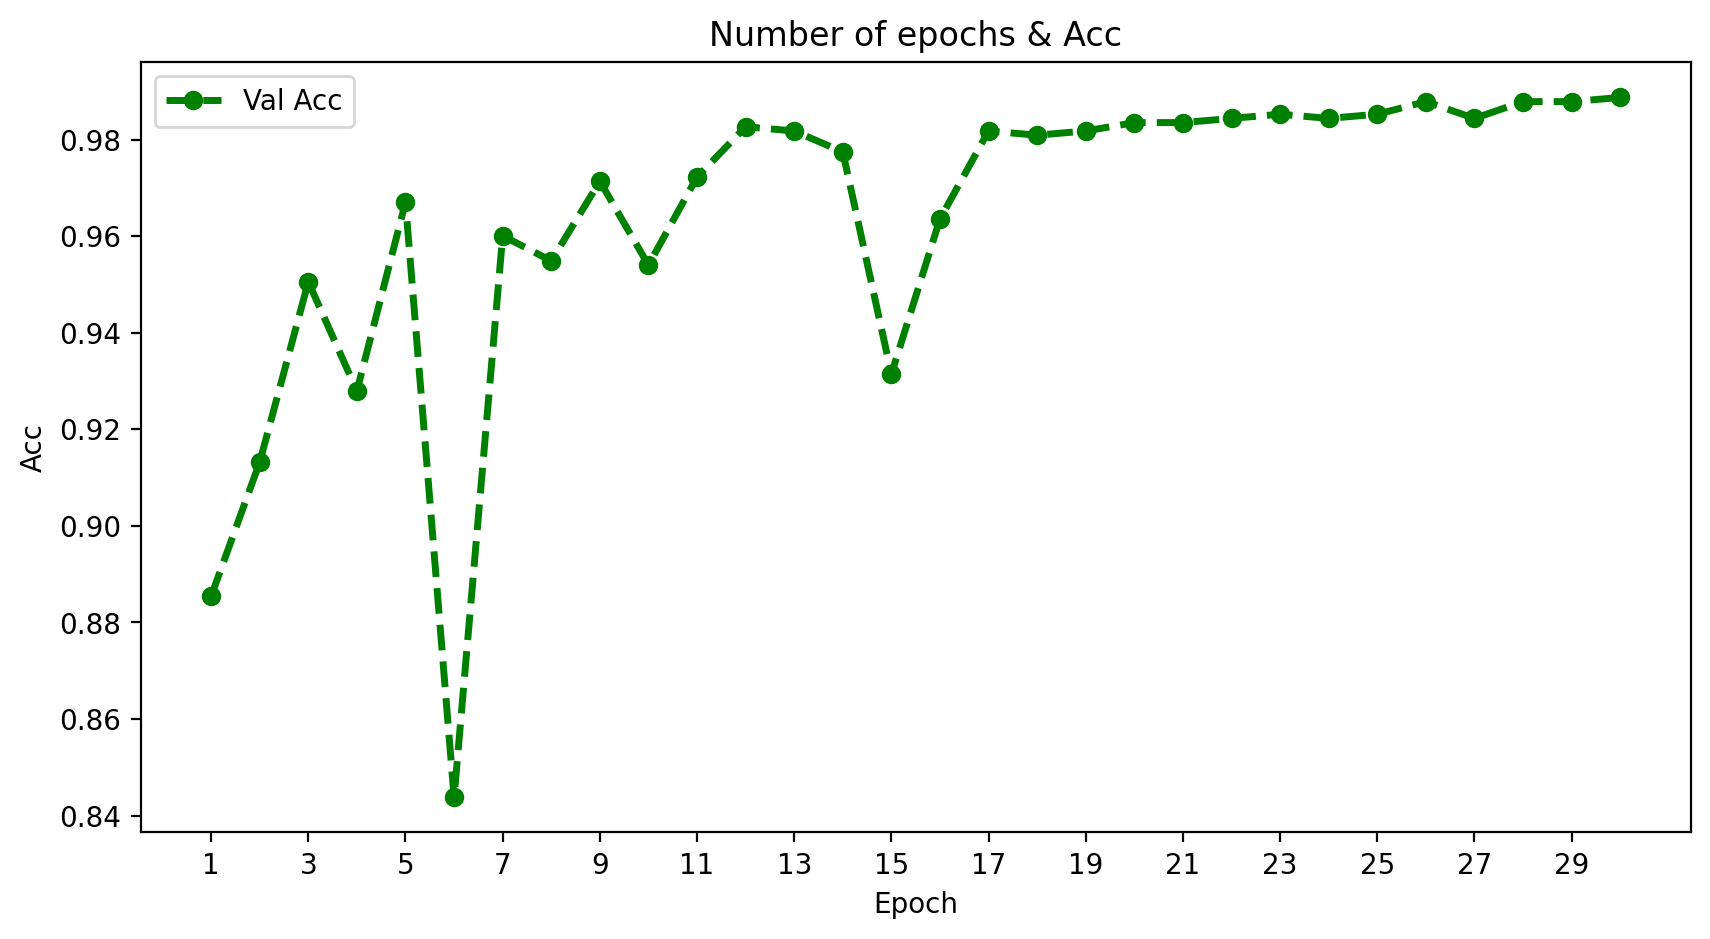

In [25]:
epoch_count = range(1,31)
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, val_acc, '--bo',color= 'green', linewidth = '2.5', label='line with marker')
plt.legend(['Val Acc'])
plt.title('Number of epochs & Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.xticks(np.arange(1,31,2))
plt.show();

# Visualize Model Predictions

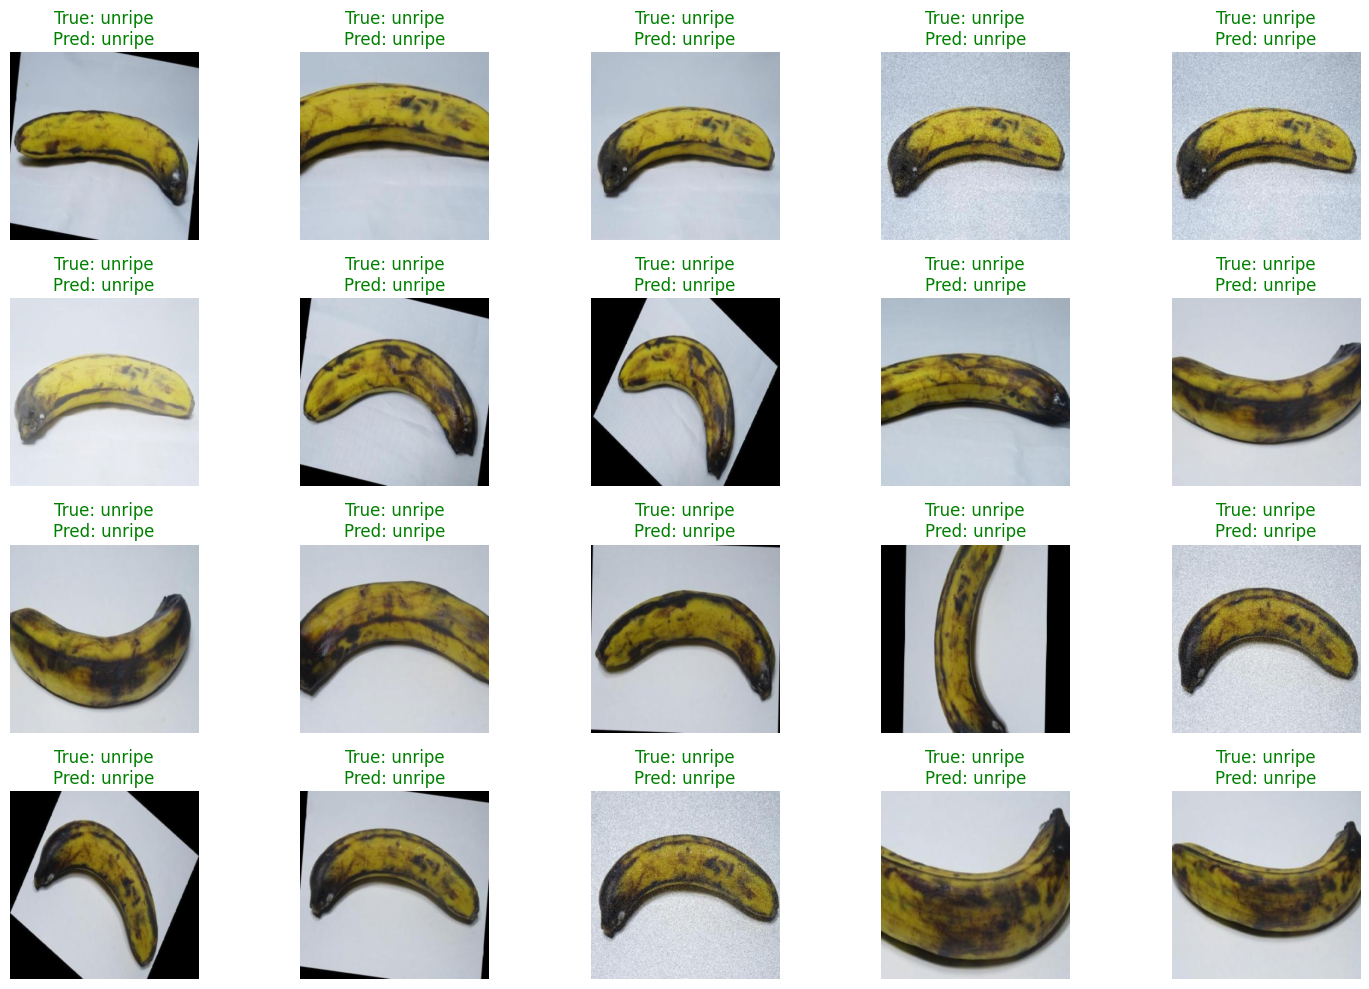

In [26]:
# Load the best model
model.load_state_dict(torch.load("resnet_Model.pth"))

def visualize_predictions(model, dataloader, class_names, num_samples=20):
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            
            # Store batch data
            all_images.extend(inputs.cpu())
            all_labels.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
            if len(all_images) >= num_samples:
                break
    
    # Limit to requested number of samples
    all_images = all_images[:num_samples]
    all_labels = all_labels[:num_samples]
    all_preds = all_preds[:num_samples]
    
    # Visualize
    fig, axes = plt.subplots(4, 5, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (img, label, pred) in enumerate(zip(all_images, all_labels, all_preds)):
        if i >= len(axes):
            break
            
        # Denormalize image
        img = img.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Display
        axes[i].imshow(img)
        color = 'green' if label == pred else 'red'
        axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}", color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions(model, test_loader, class_names)

In [27]:
# def predict_image(img, model):
#     """Converts image to array and return the predicted class
#         with highest probability"""
#     # Convert to a batch of 1
#     xb = to_device(img.unsqueeze(0), DEVICE)
#     # Get predictions from model
#     yb = model(xb)
#     # Pick index with highest probability
#     _, preds  = torch.max(yb, dim=1)
#     # Retrieve the class label

#     return test_dataset.classes[preds[0].item()]

In [28]:
# # predicting first image
# img, label = test_dataset[1]
# plt.imshow(img.permute(1, 2, 0))
# print(Fore.GREEN)
# print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [29]:
# # predicting first image
# img, label = test_ds[15]
# plt.imshow(img.permute(1, 2, 0))
# print(Fore.GREEN)
# print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))